# Vision transformer para clasificación

Este notebook demuestra cómo implementar un Vision Transformer (ViT) para la clasificación binaria de imágenes (cactus vs. no cactus) utilizando la librería vit_pytorch. La aplicación está orientada a proyectos ecológicos de monitoreo en reservas de la biósfera.

## Vision transformer

Un Vision Transformer (ViT) es una arquitectura de red neuronal que adapta el mecanismo de transformers (originalmente diseñado para procesamiento de lenguaje natural) al análisis de imágenes. En lugar de usar convoluciones como las CNN tradicionales, el ViT divide la imagen en parches secuenciales, los aplana y los trata como "tokens" de entrada, similares a las palabras en un texto. Estos parches se procesan mediante capas de self-attention, que capturan relaciones globales entre regiones de la imagen, permitiendo modelar dependencias de largo alcance. Aunque requiere más datos para entrenar que una CNN, el ViT logra un rendimiento competitivo en clasificación, especialmente cuando se pre-entrena a gran escala, y su diseño escalable lo hace ideal para tareas donde la comprensión del contexto espacial es crítica, como en la identificación de especies vegetales.
## vit-pytorch

La librería vit-pytorch (creada por Phil Wang, alias lucidrains) es una implementación modular y fácil de usar de Vision Transformers (ViT) en PyTorch, diseñada para acelerar la experimentación con arquitecturas basadas en transformers para visión por computadora. 

Características Clave:
    
- Implementación Pre-construida del ViT. Incluye la arquitectura estándar de ViT (propuesta en An Image is Worth 16x16 Words) con soporte para personalización (tamaño de parches, capas de atención, etc.).

- Soporte para imágenes de cualquier tamaño (no solo dimensiones fijas). Variantes y Extensiones Populares

- Modelos como DeepViT, CaiT, CrossViT, PiT (Pyramid Vision Transformer), y más.

- Efficient Attention: Opciones para reducir el coste computacional (ej. Linformer o Performer).

- Funcionalidades Adicionales

- Distillation: Soporte para knowledge distillation (ej. DeiT).

- Token-to-Token (T2T): Mejora la representación local de parches.

- MAE (Masked Autoencoder): Para pre-entrenamiento auto-supervisado.

- Simplicidad y Flexibilidad

- Diseño modular: Permite cambiar componentes (ej. cabezas de clasificación, esquemas de embedding) con pocas líneas de código.

In [1]:
# instalar vit_pytorch y linformer
!pip -q install vit_pytorch linformer seaborn

### Libraries

In [2]:
from __future__ import print_function
import glob
from itertools import chain
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
#from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from vit_pytorch.efficient import ViT
from collections import Counter

In [3]:
print(f"Torch: {torch.__version__}")

print("GPU is available:", torch.cuda.is_available())
device = 'cuda'

Torch: 2.6.0+cu126
GPU is available: True


In [4]:
# semillas para reproducibilidad

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

## Cactus dataset

Este conjunto de datos, disponible en Kaggle bajo el nombre *Cactus Aerial Photos*, está diseñado para entrenar modelos de clasificación binaria capaces de distinguir entre imágenes aéreas que contienen cactus y aquellas que no. Fue creado con fines de monitoreo ecológico, particularmente útil para estudiar reservas naturales como la de Tehuacán-Cuicatlán en México.

El dataset contiene un total de 17,600 fotografías aéreas en alta resolución (1,600 × 1,200 píxeles), divididas en dos categorías principales: aproximadamente 13,000 imágenes muestran cactus claramente visibles, mientras que las 4,600 restantes capturan terrenos áridos sin presencia de estas plantas. Esta distribución presenta un ligero desbalanceo que podría requerir técnicas de ajuste durante el entrenamiento.


### Download data

In [5]:
!wget https://jivg.org/wp-content/uploads/2024/07/cactus_course_dataset.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [6]:
!unzip cactus_course_dataset.zip

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


### Load data

In [7]:
base_dir = './cactus_dataset/cactus_course_dataset'
train_dir = os.path.join(base_dir, 'training_set/')
val_dir = os.path.join(base_dir, 'validation_set/')

In [8]:
# List all image paths in the training set
train_list = glob.glob(os.path.join(train_dir, '**', '*.jpg'), recursive=True)
val_list = glob.glob(os.path.join(val_dir, '**', '*.jpg'), recursive=True)

print(f"Train data (Total images): {len(train_list)}")
print(f"Val data (Total images): {len(val_list)}")

Train data (Total images): 17500
Val data (Total images): 4000


In [9]:
# Extract labels from folder names
labels = [os.path.basename(os.path.dirname(path)) for path in train_list]

print(f"Labels: {set(labels)}")

Labels: {'no_cactus', 'cactus'}


Random indices: [ 3248 14677 16812 12536  3219 12698 14679  9649  7275]


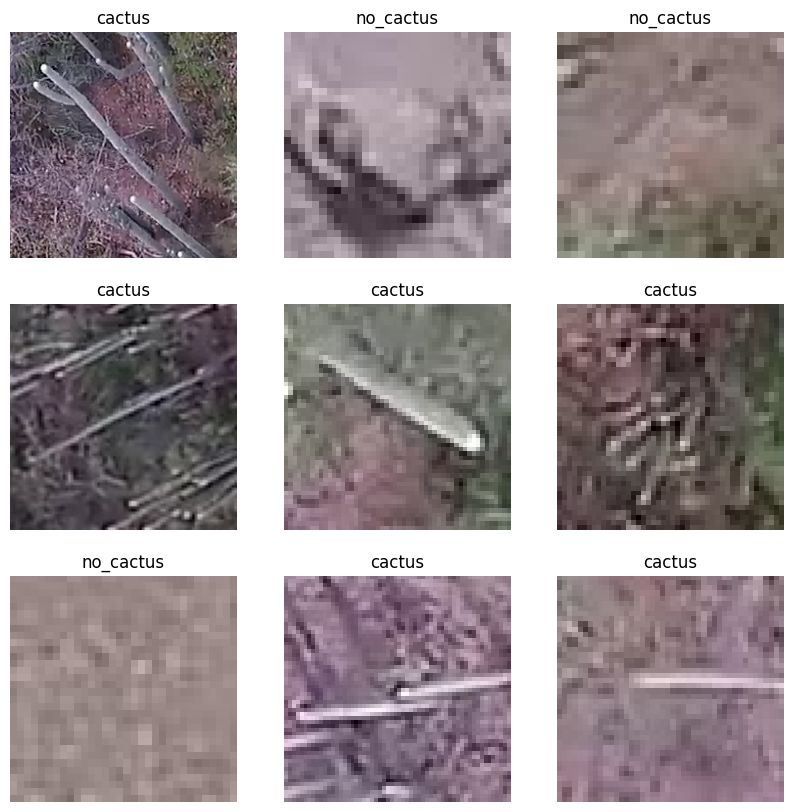

In [11]:
# Randomly select 9 images and plot them
random_idx = np.random.choice(len(train_list), size=9, replace=False)
print(f"Random indices: {random_idx}")
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for idx, ax in zip(random_idx, ax.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)
    ax.axis('off')

plt.show()

### Split

Aqui vamos a dividir el conjunto de datos de train para validación cruzada o hold out

In [12]:
# opcional si es que no tuvieramos un set de validación
#train_list, val_list = train_test_split(train_list, test_size=0.2, random_state=42)

print(f"Train data (Total images): {len(train_list)}")
print(f"Val data (Total images): {len(val_list)}")
#print(f"Test data (Total images): {len(test_list)}")


Train data (Total images): 17500
Val data (Total images): 4000


In [13]:
train_labels = [ os.path.basename(os.path.dirname(path)) for path in train_list]
train_counts = Counter(train_labels)

val_labels = [os.path.basename(os.path.dirname(path)) for path in val_list]
val_counts = Counter(val_labels)

#test_labels = [path.split('/')[-2] for path in test_list]
#test_counts = Counter(test_labels)

data = {
    "Clase": ["Cactus", "No Cactus"],
    "Entrenamiento": [train_counts.get("cactus", 0), train_counts.get("no_cactus", 0)],
    "Validación": [val_counts.get("cactus", 0), val_counts.get("no_cactus", 0)],
    #"Prueba": [test_counts.get("cactus", 0), test_counts.get("no_cactus", 0)]
}

set_classes = pd.DataFrame(data)

set_classes

,Clase,Entrenamiento,Validación
0,Cactus,13136,3000
1,No Cactus,4364,1000


### Aumentación de datos

In [14]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

### Load Datasets

In [15]:
class CactusDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = os.path.basename(os.path.dirname(img_path))
        label = 1 if label == "cactus" else 0

        return img_transformed, label

In [16]:
train_data = CactusDataset(train_list, transform=train_transforms)
val_data = CactusDataset(val_list, transform=val_transforms)
#test_data = CactusDataset(test_list, transform=test_transforms)

In [17]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
#test_loader = DataLoader(test_data, batch_size, shuffle=False)

In [18]:
print(f"Train data | Total images: {len(train_data)} | Total batches: {len(train_loader)}")
print(f"Val data | Total images: {len(val_data)} | Total batches: {len(val_loader)}")
#print(f"Test data | Total images: {len(test_data)} | Total batches: {len(test_loader)}")

Train data | Total images: 17500 | Total batches: 274
Val data | Total images: 4000 | Total batches: 63


### Verification 

Verificar si se está cargando de forma correcta el dataset

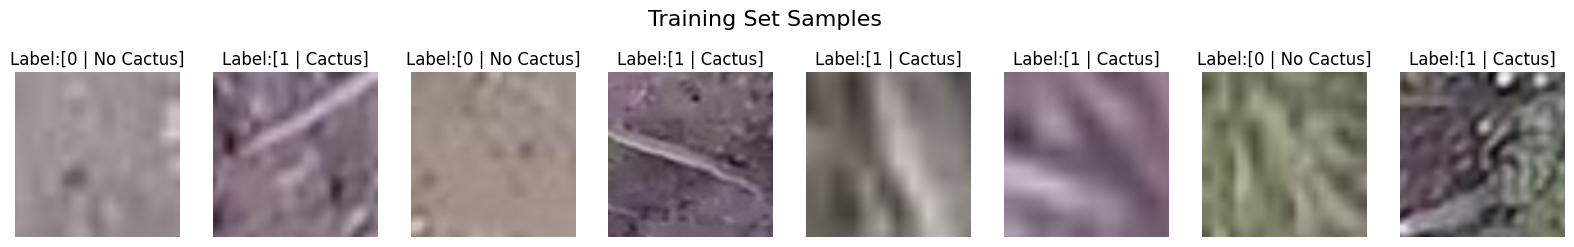

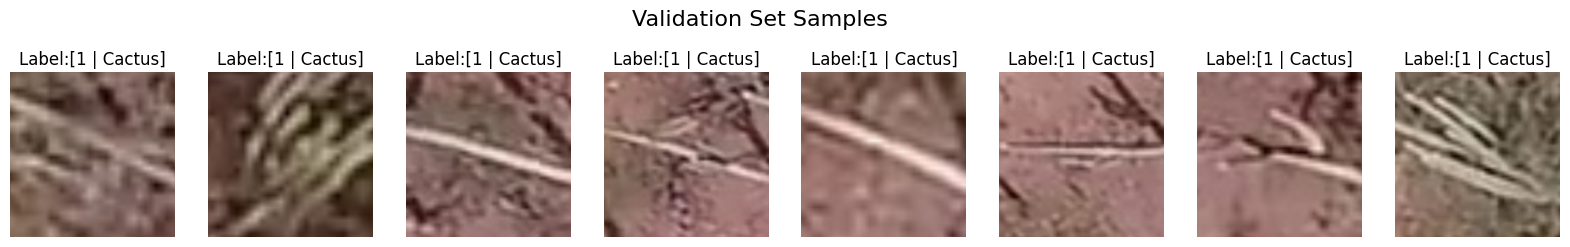

In [19]:
def show_images(dataloader, title):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    fig.suptitle(title, fontsize=16)

    for i in range(8):
        img = images[i]
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting

        # Display the image and label
        axes[i].imshow(img)
        axes[i].set_title(f"Label:[{labels[i]} | {'Cactus' if labels[i] == 1 else 'No Cactus'}]")
        axes[i].axis('off')

    plt.show()

# Each dataset
show_images(train_loader, "Training Set Samples")
show_images(val_loader, "Validation Set Samples")
#show_images(test_loader, "Test Set Samples")


## Model | Visual Transformer

### Linformer

In [20]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [21]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

Training settings | Loss function | Optimizer | Scheduler

In [25]:
# Training settings
epochs = 3
lr = 3e-1
gamma = 0.1

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

Model training

In [26]:
# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    # Training
    model.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    train_losses.append(epoch_loss.item())
    train_accuracies.append(epoch_accuracy.item())

    # Validation
    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

        val_losses.append(epoch_val_loss.item())
        val_accuracies.append(epoch_val_accuracy.item())

    print(
        f"Epoch: {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, "
        f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}"
    )


Epoch: 1, Train Loss: 1.1304, Train Acc: 0.7297, Val Loss: 0.5696, Val Acc: 0.7440
Epoch: 2, Train Loss: 0.5672, Train Acc: 0.7504, Val Loss: 0.5699, Val Acc: 0.7440
Epoch: 3, Train Loss: 0.5718, Train Acc: 0.7505, Val Loss: 0.5729, Val Acc: 0.7440


Training and validation loss | Training and validation accuracy

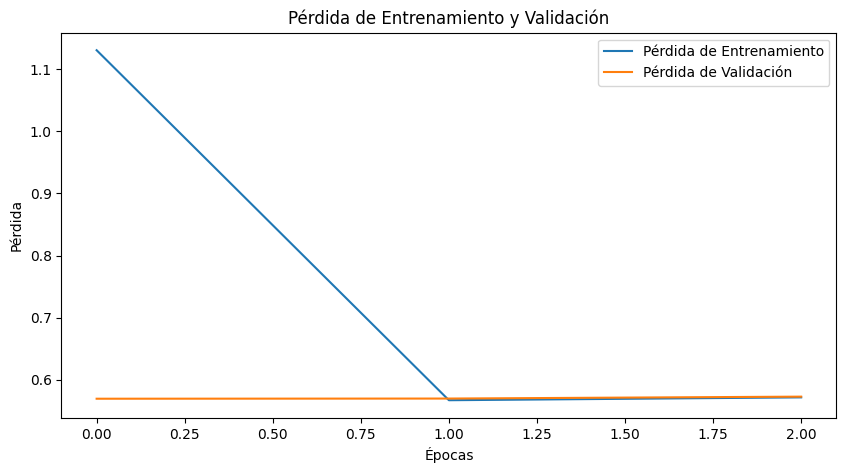

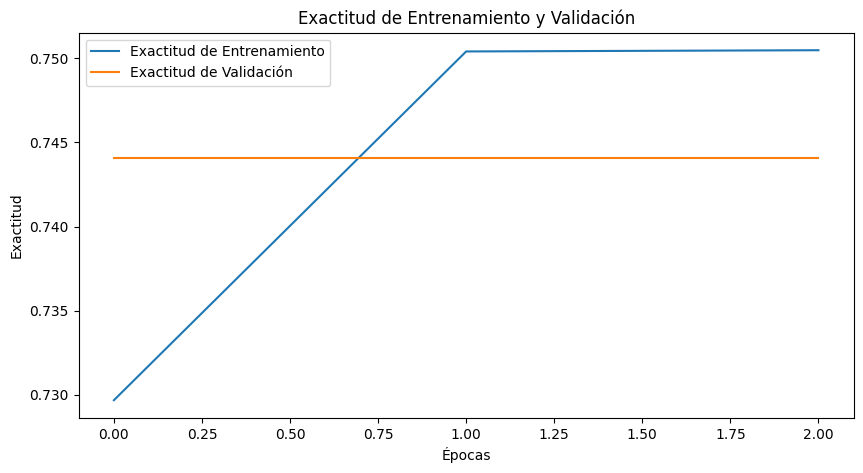

In [27]:
# Gráfica de pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()
plt.savefig("perdida_entrenamiento_validacion.png")
plt.show()

# Gráfica de exactitud de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Exactitud de Entrenamiento')
plt.plot(val_accuracies, label='Exactitud de Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.title('Exactitud de Entrenamiento y Validación')
plt.legend()
plt.savefig("exactitud_entrenamiento_validacion.png")
plt.show()
